In [4]:
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from glob import glob
import cv2
from matplotlib import animation
from IPython import display
import torch
from torch.nn import functional as F
from tqdm.auto import trange, tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [5]:
train_descriptions = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
train_coord_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
train_coord_df = train_coord_df.merge(train_descriptions, on=["series_id", "study_id"], how="left")
train_df = pd.read_csv("../../input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
train_df["fold_id"] = -1
for i, (train_index, valid_index) in enumerate(GroupKFold(n_splits=5).split(train_df, np.arange(len(train_df)), train_df.study_id)):
    train_df.loc[valid_index, "fold_id"] = i
train_coord_df = train_coord_df.merge(train_df.loc[:, ["study_id", "fold_id"]], on=["study_id"], how="left")
train_coord_df = train_coord_df.sort_values(by=["study_id", "series_id", "level", "condition"]).reset_index(drop=True)

In [11]:
coord_label_num = train_coord_df.groupby("series_id").count().sort_values("series_id").study_id.to_numpy()
SCS = train_coord_df.groupby("series_id").head(1).sort_values("series_id").condition.to_numpy() 
series_id =  train_coord_df.groupby("series_id").head(1).sort_values("series_id").series_id
new_series_id = series_id[((SCS == "Spinal Canal Stenosis") & (coord_label_num == 5)) | ((SCS != "Spinal Canal Stenosis") & (coord_label_num == 10))]
new_train_coord_df = train_coord_df[train_coord_df.series_id.isin(new_series_id)].sort_values(by=["series_id", "level"]).reset_index(drop=True)
new_train_coord_df = new_train_coord_df[new_train_coord_df.series_description.isin(["Sagittal T1", "Sagittal T2/STIR"])]
new_train_coord_df

study_id   series_id  instance_number  \
0      3996069892       10996               13   
1      3996069892       10996                6   
2      3996069892       10996               12   
3      3996069892       10996                6   
4      3996069892       10996               12   
...           ...         ...              ...   
43925   916362094  4294540297               11   
43926   916362094  4294540297               10   
43927   916362094  4294540297               10   
43928   916362094  4294540297                9   
43929   916362094  4294540297               10   

                              condition  level           x           y  \
0       Left Neural Foraminal Narrowing  L1/L2  266.827697  166.544283   
1      Right Neural Foraminal Narrowing  L1/L2  264.630404  163.686737   
2       Left Neural Foraminal Narrowing  L2/L3  252.811594  205.294686   
3      Right Neural Foraminal Narrowing  L2/L3  258.064459  197.391921   
4       Left Neural Foraminal Narrowing  L3/L4  249.513688  243.220612   
...                                 ...    ...         ...         ...   
43925             Spinal Canal Stenosis  L1/L2  254.122744  159.104693   
43926             Spinal Canal Stenosis  L2/L3  239.566787  209.241877   
43927             Spinal Canal Stenosis  L3/L4  229.054152  256.144404   
43928             Spinal Canal Stenosis  L4/L5  231.480144  300.620939   
43929             Spinal Canal Stenosis  L5/S1  239.566787  341.054152   

      series_description  fold_id  
0            Sagittal T1        0  
1            Sagittal T1        0  
2            Sagittal T1        0  
3            Sagittal T1        0  
4            Sagittal T1        0  
...                  ...      ...  
43925   Sagittal T2/STIR        2  
43926   Sagittal T2/STIR        2  
43927   Sagittal T2/STIR        2  
43928   Sagittal T2/STIR        2  
43929   Sagittal T2/STIR        2  

[29120 rows x 9 columns]

In [17]:
series_ids = new_train_coord_df.series_id.unique()
max_crop_range = 0
crop_ranges = []
for series_id in tqdm(new_train_coord_df.series_id.unique()):
    instance_len = len(glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_id}/*.dcm"))
    series_df = new_train_coord_df[new_train_coord_df.series_id == series_id]
    if len(series_df) == 10:
        new_series_df = series_df.iloc[::2].reset_index(drop=True)
        new_series_df.loc[:, ["instance_number", "x", "y"]] = \
            (series_df.iloc[0::2].loc[:, ["instance_number", "x", "y"]].to_numpy().astype(np.float32) \
            + series_df.iloc[1::2].loc[:, ["instance_number", "x", "y"]].to_numpy().astype(np.float32)) / 2
    else:
        assert len(series_df) == 5
        new_series_df = series_df.reset_index(drop=True)
    crop_range = max(abs((instance_len / 2) - new_series_df.instance_number.min()), abs((instance_len / 2) - new_series_df.instance_number.max())) / instance_len
    if max_crop_range < crop_range:
        max_crop_range = crop_range
    crop_ranges.append(crop_range)
    # print(new_series_df.instance_number.min(), new_series_df.instance_number.max(), instance_len, crop_range)
    # break
max_crop_range


  0%|          | 0/3861 [00:00<?, ?it/s]

/tmp/ipykernel_772249/3109668531.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9.5 9.  8.5 8.5 9. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_series_df.loc[:, ["instance_number", "x", "y"]] = \
/tmp/ipykernel_772249/3109668531.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.5 8.5 8.  8.  8. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_series_df.loc[:, ["instance_number", "x", "y"]] = \
/tmp/ipykernel_772249/3109668531.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.  8.  8.5 9.  9. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_series_df.loc[:, ["instance_number", "x", "y"]] = \
/tmp/ipykernel_772249/310

0.4523809523809524

array([2278678071, 2289719834, 2294821327, 2433869833, 2914998765,
       3230157587])

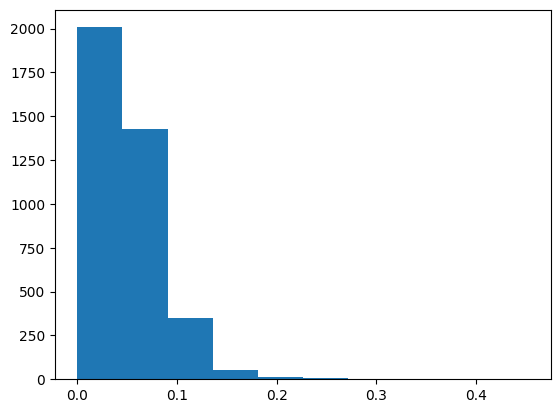

In [22]:
plt.hist(crop_ranges)
sum(np.asarray(crop_ranges) > 0.25)
new_train_coord_df.series_id.unique()[np.asarray(crop_ranges) > 0.25]

In [25]:
series_id = 2278678071
new_train_coord_df[new_train_coord_df.series_id == series_id]

study_id   series_id  instance_number  \
23080  1395773918  2278678071                3   
23081  1395773918  2278678071                3   
23082  1395773918  2278678071                3   
23083  1395773918  2278678071                3   
23084  1395773918  2278678071                3   
23085  1395773918  2278678071                3   
23086  1395773918  2278678071                3   
23087  1395773918  2278678071                3   
23088  1395773918  2278678071                3   
23089  1395773918  2278678071                3   

                              condition  level           x           y  \
23080   Left Neural Foraminal Narrowing  L1/L2  287.226374  160.070330   
23081  Right Neural Foraminal Narrowing  L1/L2  286.498915  161.596529   
23082   Left Neural Foraminal Narrowing  L2/L3  272.597802  207.331868   
23083  Right Neural Foraminal Narrowing  L2/L3  269.839479  206.021692   
23084   Left Neural Foraminal Narrowing  L3/L4  266.971429  254.593407   
23085  Right Neural Foraminal Narrowing  L3/L4  262.065076  256.000000   
23086   Left Neural Foraminal Narrowing  L4/L5  266.971429  298.479121   
23087  Right Neural Foraminal Narrowing  L4/L5  268.728850  302.646421   
23088   Left Neural Foraminal Narrowing  L5/S1  272.597802  334.487912   
23089  Right Neural Foraminal Narrowing  L5/S1  274.281996  334.854664   

      series_description  fold_id  
23080        Sagittal T1        0  
23081        Sagittal T1        0  
23082        Sagittal T1        0  
23083        Sagittal T1        0  
23084        Sagittal T1        0  
23085        Sagittal T1        0  
23086        Sagittal T1        0  
23087        Sagittal T1        0  
23088        Sagittal T1        0  
23089        Sagittal T1        0

In [26]:
len(glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_id}/*.dcm"))

14

In [28]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype
        pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

    intercept = float(dcm.RescaleIntercept) if hasattr(dcm, "RescaleIntercept") else 0
    slope = float(dcm.RescaleSlope) if hasattr(dcm, "RescaleSlope") else 1
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2

    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)
    return pixel_array

anno_map = {
    "L1/L2": (255, 0, 0),
    "L2/L3": (0, 255, 0),
    "L3/L4": (0, 0, 255),
    "L4/L5": (0, 127, 127),
    "L5/S1": (127, 0, 127),
}

def get_volume(series_df: pd.DataFrame):
    volume = []
    img_paths = glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_df.series_id.iloc[0]}/*.dcm")
    for i in range(len(img_paths)):
        img_path = glob(f"../../input/rsna-2024-lumbar-spine-degenerative-classification/train_images/**/{series_df.series_id.iloc[0]}/{i+1}.dcm", recursive=True)[0]
        dicom = pydicom.dcmread(img_path)
        # print(dicom.Rows, dicom.Columns)
        volume.append(standardize_pixel_array(dicom))
    volume = np.stack(volume)
    volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-6)
    volume = (volume * 255)#.astype(np.uint8)
    volume = np.stack([volume, volume, volume], -1)
    label = np.zeros_like(volume).astype(np.uint8)
    for i in range(len(volume)):
        annotation = series_df[series_df.instance_number == i + 1]
        for j in range(len(annotation)):
            label[i] = cv2.circle(label[i], (int(annotation.x.iloc[j]), int(annotation.y.iloc[j])), max(label.shape[1], label.shape[2]) // 25, color=anno_map[annotation.level.iloc[j]], thickness=-1)
    volume += label * 0.2
    return volume.clip(0, 255).astype(np.uint8)

volume = get_volume(new_train_coord_df[new_train_coord_df.series_id == series_id])
print(volume.shape)
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(volume[0])
def draw(i):
    im.set_array(volume[i])
    return [im]
anim = animation.FuncAnimation(
    fig, draw, frames=volume.shape[0], interval=200, blit=True
)
plt.close()
display.HTML(anim.to_jshtml())

(14, 512, 512, 3)
